# 'Cowboy Cigarettes' Case Study 

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  
    

## Sourcing and Loading

### Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
import seaborn as sns
import pmdarima as pm
import warnings
%matplotlib inline

/Users/allenwang/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv')

### Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [5]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [6]:
cigData.isnull().values.any()

False

## Cleaning, transforming and visualizing

### Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [7]:
cigData.drop('Unnamed: 0', axis = 1, inplace = True)

### Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
cigData.rename(columns = {"Time":"Month"}, inplace = True)

Call a head() to check this has worked. 

In [9]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [10]:
cigData['Month'] = pd.to_datetime(cigData['Month'])
cigData.set_index('Month', inplace = True)

Perfect! 

### Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [11]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [12]:
type(y)

pandas.core.series.Series

### Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [13]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### Plotting `y`

<Axes: xlabel='Month'>

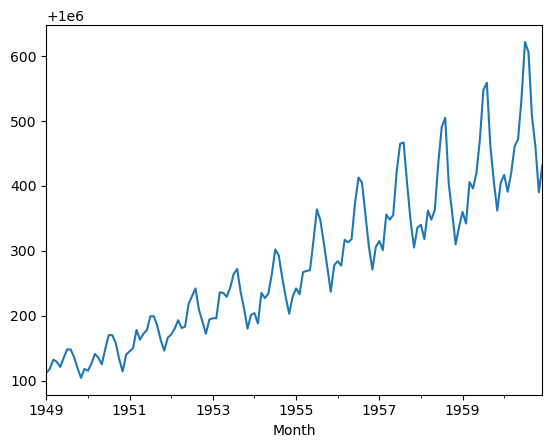

In [14]:
y.plot()

## Modelling 
### Decomposition
We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

-------------------------------

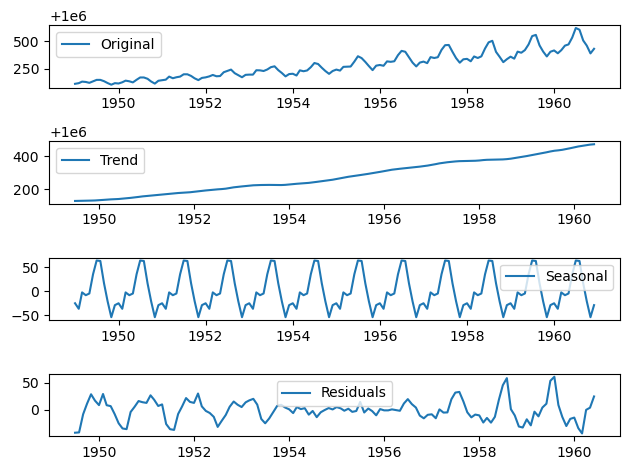

In [15]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition= seasonal_decompose(y)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### Testing for stationarity with Dickey-Fuller
When doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the Dickey-Fuller test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [16]:
from statsmodels.tsa.stattools import adfuller

adfuller(y)

(0.8153688792064129,
 0.9918802434376467,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390155)

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### Making the data stationary 
Let's recall what it looks like. 

<Axes: xlabel='Month'>

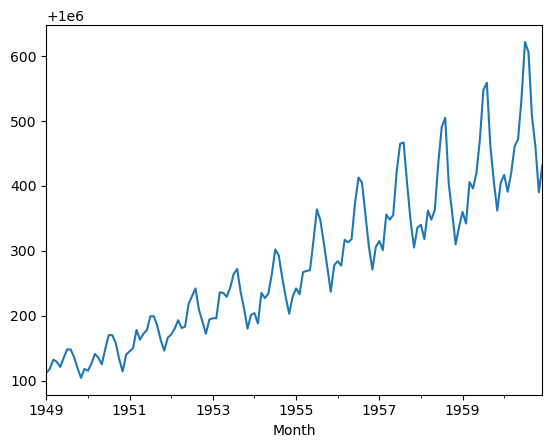

In [17]:
y.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [18]:
# Declare a variable called y_log
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

<Axes: xlabel='Month'>

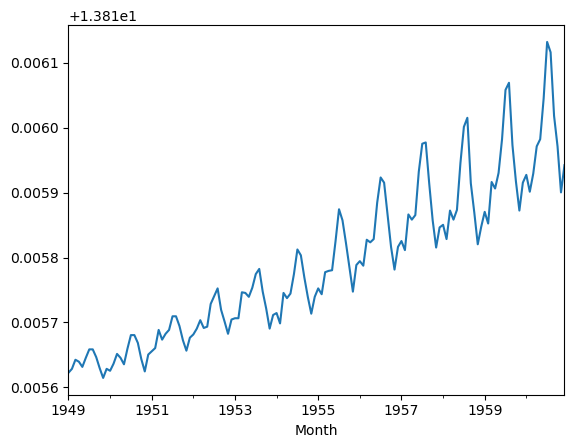

In [19]:
y_log.plot()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [20]:
adfuller(y_log.diff().dropna())

(-2.829562441918172,
 0.05417348562589708,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 -2548.350599576877)

Our p-value is still greater than 0.05, so we can't reject the null hypothesis that the data is nonstationary.

In [21]:
residual_transformed = np.log(residual.diff(12)+50).dropna()

It looks like there's a seasonal component occuring every year so since we have monthly data, we indicate a difference of 12 for seasonality. We then want to apply a log transformation to lessen the variance to further achieve stationarity and because we want to apply a log transformation, we add 50 to all the values because log transformation only works on non-negative values.

<Axes: title={'center': 'Residuals with log transformation and lag 1 differencing'}, xlabel='Month'>

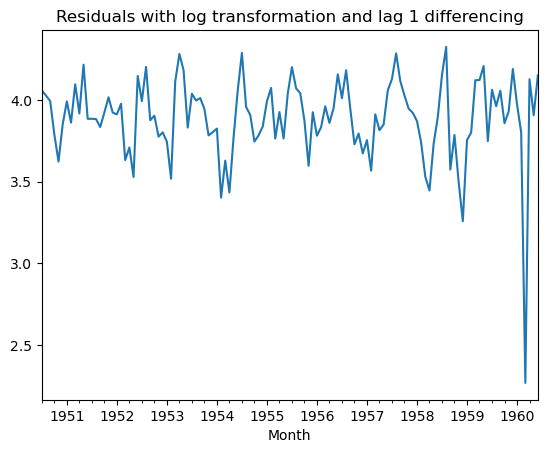

In [22]:
residual_transformed.plot(title = 'Residuals with log transformation and lag 1 differencing')

In [23]:
adfuller(residual_transformed)

(-5.128380198002639,
 1.2289235320627592e-05,
 9,
 110,
 {'1%': -3.4912451337340342,
  '5%': -2.8881954545454547,
  '10%': -2.5809876033057852},
 6.896435624452664)

It looks like our data is stationary now since -5.128 < -2.888 for the critical value of 5%.

In [24]:
# define helper plot function for visualization
def plots(data, lags=None):
    plt.figure(figsize = (10,8))
    layout = (3,1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

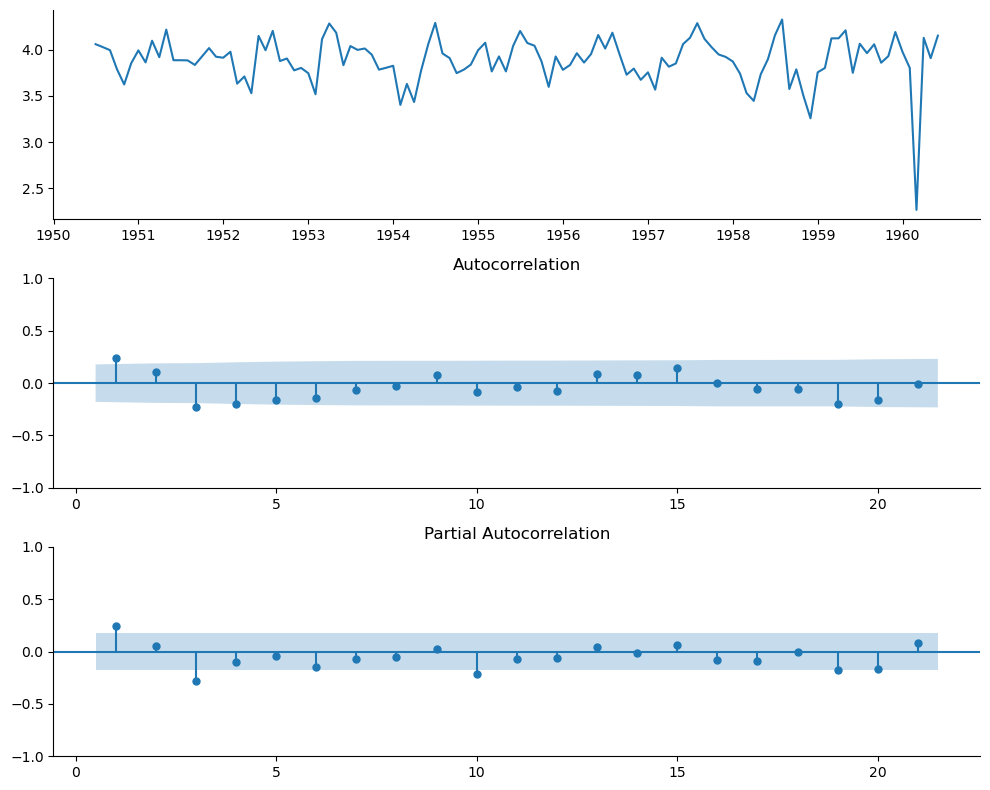

In [25]:
plots(residual_transformed)

The general rule for determining AR and MA components is that a sharp cutoff at the ACF plot indicates a MA component and a sharp cutoff at the PACF plot indicates an AR component. Since we see somewhat of a sharp cutoff at lag 1, for both plots we can reason that the model has ARIMA(1,0,1) but with uncertainty since the lag 1 values are not that high. From the looks of it, we're going to be using SARIMA because there is a seasonal component in our time series.

### The SARIMA model

Recall that SARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `SARIMA`. 

In [26]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Fit a SARIMA model to our data

Plot the ACF and PACF graphs of the seasonally differenced data to determine the parameters of the seasonal component of the SARIMA model.

General rule of thumb is if there is a strong seasonal component in the model, you should try (0,1,1) for the seasonal component of SARIMA.

In [27]:
sar = sm.tsa.statespace.SARIMAX(y, 
                                order=(1,0,1), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
sar.summary()

/Users/allenwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/allenwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81515D+01    |proj g|=  4.53338D+01

At iterate    5    f=  4.11469D+00    |proj g|=  5.05087D-01

At iterate   10    f=  3.94232D+00    |proj g|=  4.46708D-01

At iterate   15    f=  3.92919D+00    |proj g|=  2.66561D-01

At iterate   20    f=  3.85489D+00    |proj g|=  2.07810D-01

At iterate   25    f=  3.85280D+00    |proj g|=  2.82413D-03

At iterate   30    f=  3.85171D+00    |proj g|=  1.56272D-01

At iterate   35    f=  3.84093D+00    |proj g|=  3.93894D-01

At iterate   40    f=  3.81674D+00    |proj g|=  1.38391D-01

At iterate   45    f=  3.79898D+00    |proj g|=  1.89375D-02

At iterate   50    f=  3.79894D+00    |proj g|=  9.03381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/allenwang/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -547.047
Date:                            Mon, 01 Jul 2024   AIC                           1104.095
Time:                                    18:15:28   BIC                           1118.509
Sample:                                01-01-1949   HQIC                          1109.952
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     31.3652      6.340      4.947      0.000      18.938      43.792
ar.L1          0.0627      0.185      0.340      0.734      -0.299       0.424
ma.L1          0.1923      0.229      0.841      0.400      -0.256       0.640
ma.S.L12      -0.0886      0.029     -3.064      0.002      -0.145      -0.032
sigma2       182.3487     21.435      8.507      0.000     140.337     224.360
===================================================================================
Ljung-Box (L1) (Q):                  28.44   Jarque-Bera (JB):                 9.79
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               2.07   Skew:                            -0.45
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

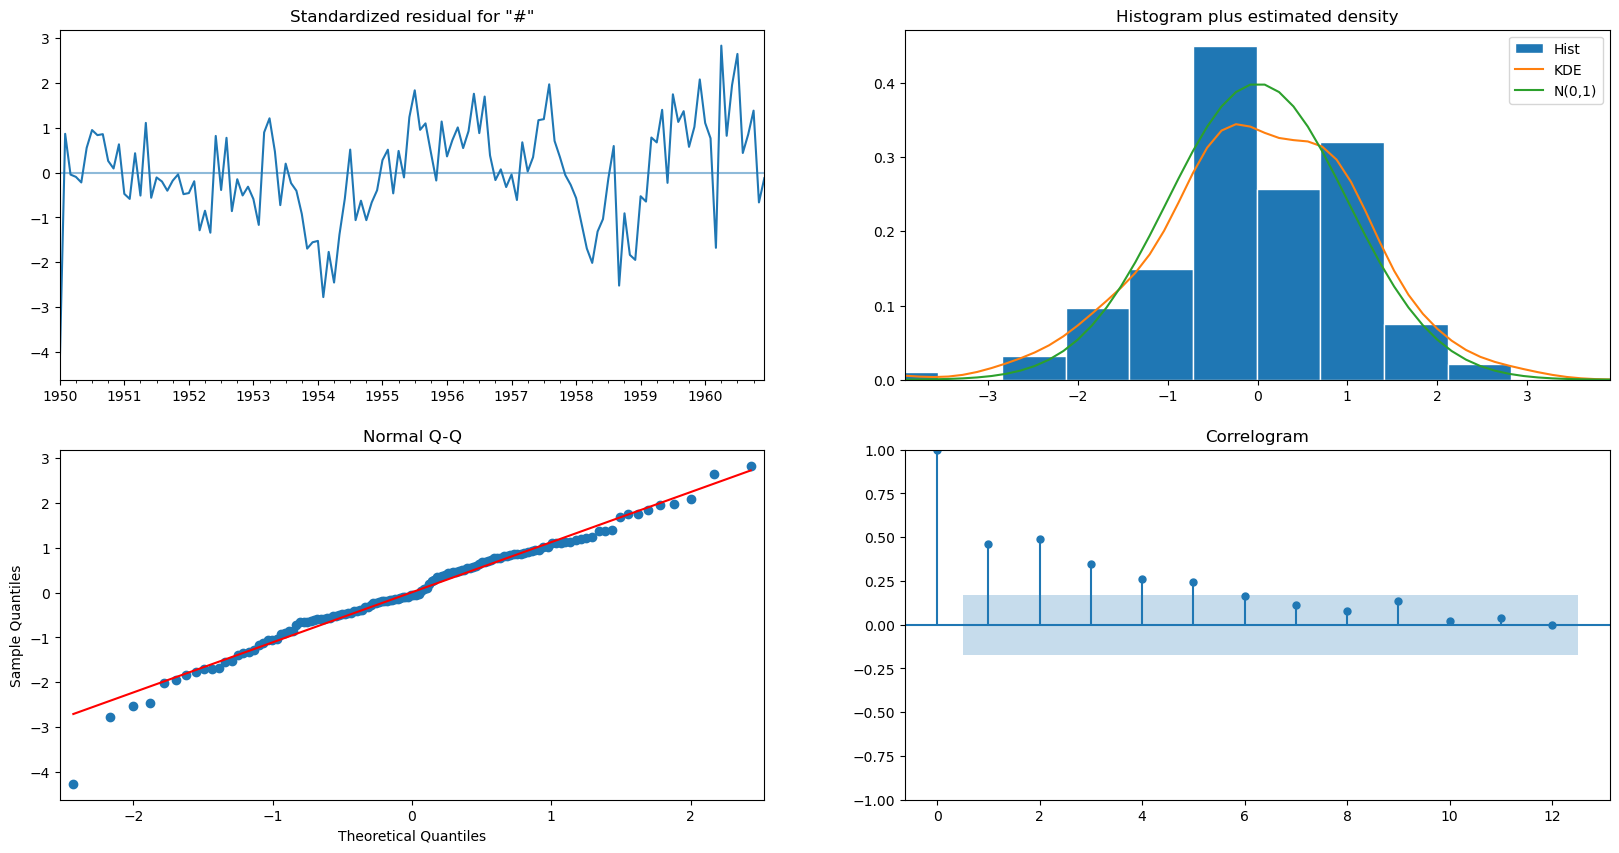

In [28]:
sar.plot_diagnostics(lags=12,figsize = (20,10),);

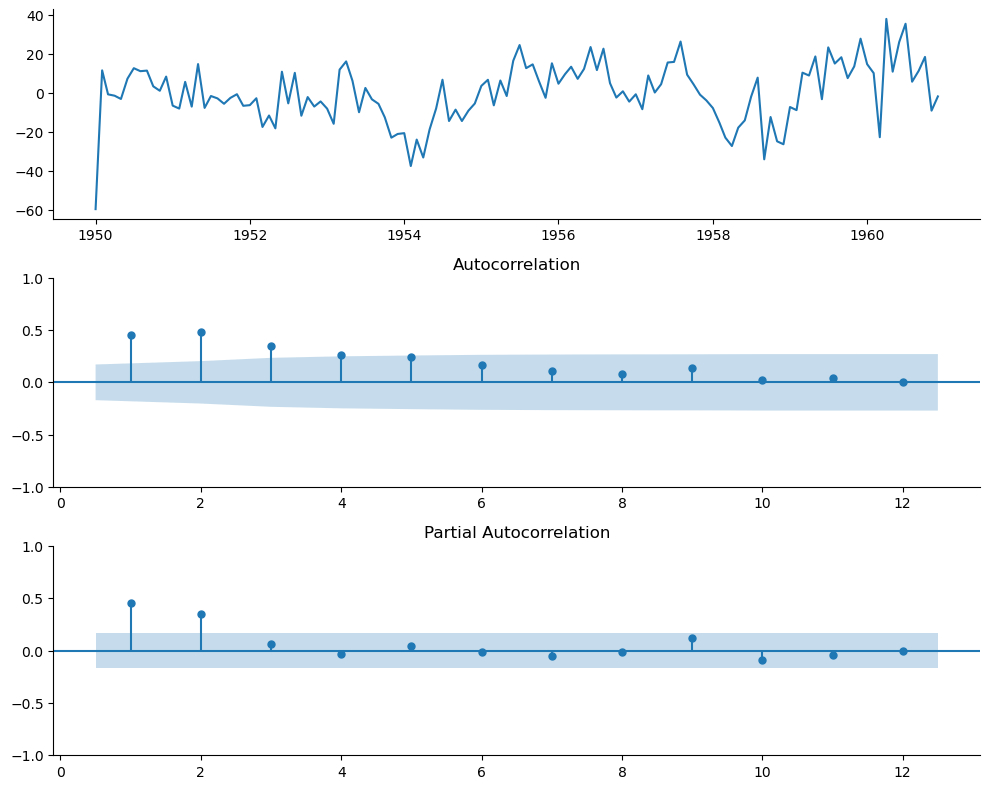

In [29]:
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

# Statistics Tests

- [Normality (Jarque-Bera)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality)
    - Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)

- [Serial correlation (Ljung-Box)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation)
    - Null hypothesis is no serial correlation in residuals (independent of each other)

- [Heteroskedasticity](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity)
    - Tests for change in variance between residuals.
    - The null hypothesis is no heteroskedasticity. That means different things depending on which alternative is selected:
        - Increasing: Null hypothesis is that the variance is not increasing throughout the sample; that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.
        - Decreasing: Null hypothesis is that the variance is not decreasing throughout the sample; that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample.
        - Two-sided (default): Null hypothesis is that the variance is not changing throughout the sample. Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

- [Durbin Watson](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)
    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)

In [30]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=9.792, p=0.007
Ljung-Box: val=148.110, p=0.000
Heteroskedasticity: val=2.072, p=0.017
Durbin-Watson: d=0.97


In [31]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(y, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1104.095, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1135.540, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1103.680, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1102.219, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1324.954, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1123.154, Time=0.07 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1100.986, Time=0.52 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1102.913, Time=0.24 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=1105.491, Time=1.01 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1105.261, Time=1.01 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1103.599, Time=0.79 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1104.075, Time=0.84 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1117.694, Time=0.47 sec
 ARIMA(1,0,1)(1,1,1)[12]

SARIMA(0,0,1)(1,1,1,12) has the best AIC criteria score. Therefore we will select that as our model to test against.

In [32]:
model = sm.tsa.statespace.SARIMAX(y, 
                                order=(0,0,1), 
                                seasonal_order=(1,1,1,12), 
                                trend='c').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31641D+01    |proj g|=  3.95907D+01

At iterate    5    f=  4.18291D+00    |proj g|=  9.54571D-01

At iterate   10    f=  3.83173D+00    |proj g|=  1.67975D-01

At iterate   15    f=  3.82435D+00    |proj g|=  4.53415D-02


/Users/allenwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/allenwang/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  3.79814D+00    |proj g|=  7.23583D-02

At iterate   25    f=  3.79780D+00    |proj g|=  1.34561D-03

At iterate   30    f=  3.79772D+00    |proj g|=  3.30578D-02

At iterate   35    f=  3.79440D+00    |proj g|=  2.74634D-01

At iterate   40    f=  3.78875D+00    |proj g|=  2.51484D-02

At iterate   45    f=  3.78821D+00    |proj g|=  2.72381D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     58      1     0     0   6.999D-06   3.788D+00
  F =   3.7881460836806156     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -545.493
Date:                            Mon, 01 Jul 2024   AIC                           1100.986
Time:                                    18:15:41   BIC                           1115.400
Sample:                                01-01-1949   HQIC                          1106.843
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.2830      5.404      3.013      0.003       5.691      26.875
ma.L1          0.2533      0.039      6.476      0.000       0.177       0.330
ar.S.L12       0.5492      0.161      3.407      0.001       0.233       0.865
ma.S.L12      -0.6428      0.156     -4.119      0.000      -0.949      -0.337
sigma2       183.9254     21.424      8.585      0.000     141.936     225.915
===================================================================================
Ljung-Box (L1) (Q):                  27.41   Jarque-Bera (JB):                15.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                            -0.62
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Cross-validation

The best model is achieved in practice not by the smallest AIC or BIC criteria, but the ability of the model to make correct predictions. Therefore, we need to cross-validate on the model and measure the error of predictions made. We're going to do this for our two models.

In [34]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

## Perform CV with our searched model with the best AIC

In [35]:
warnings.filterwarnings("ignore")
series = y
horizon = 12
start = 120
step_size = 1
order = (0,0,1)
seasonal_order = (1,1,1,12)

cv1 = cross_validate(series, horizon, start, step_size,
                    order = order,
                    seasonal_order = seasonal_order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91503D+01    |proj g|=  2.16293D+02

At iterate    5    f=  6.11383D+00    |proj g|=  2.24548D+00

At iterate   10    f=  4.17123D+00    |proj g|=  3.31669D-01


 This problem is unconstrained.



At iterate   15    f=  4.14991D+00    |proj g|=  5.61001D-01

At iterate   20    f=  4.08582D+00    |proj g|=  1.21872D-01

At iterate   25    f=  4.06426D+00    |proj g|=  7.97497D-02

At iterate   30    f=  3.76100D+00    |proj g|=  5.45122D-01

At iterate   35    f=  3.72232D+00    |proj g|=  6.65809D-03

At iterate   40    f=  3.72219D+00    |proj g|=  1.92983D-02

At iterate   45    f=  3.72111D+00    |proj g|=  1.69761D-02

At iterate   50    f=  3.72103D+00    |proj g|=  2.64810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     62      1     0     0   2.648D-04   3.721D+00
  F =   3.72103140562

 This problem is unconstrained.



At iterate   20    f=  4.08466D+00    |proj g|=  1.15372D-01

At iterate   25    f=  4.05395D+00    |proj g|=  3.48058D-02

At iterate   30    f=  3.82701D+00    |proj g|=  3.30050D-01

At iterate   35    f=  3.72051D+00    |proj g|=  1.02178D-01

At iterate   40    f=  3.71926D+00    |proj g|=  3.14042D-04

At iterate   45    f=  3.71922D+00    |proj g|=  7.64509D-03

At iterate   50    f=  3.71901D+00    |proj g|=  1.00044D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     65      1     0     0   1.000D-02   3.719D+00
  F =   3.7190100517781080     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  4.06096D+00    |proj g|=  1.26745D-01

At iterate   25    f=  3.91003D+00    |proj g|=  7.29403D-02

At iterate   30    f=  3.73387D+00    |proj g|=  2.47650D-01

At iterate   35    f=  3.72507D+00    |proj g|=  1.53944D-04

At iterate   40    f=  3.72488D+00    |proj g|=  7.25911D-03

At iterate   45    f=  3.72472D+00    |proj g|=  5.13419D-03

At iterate   50    f=  3.72469D+00    |proj g|=  8.39739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     71      1     0     0   8.397D-04   3.725D+00
  F =   3.7246905309883331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  5.16030D+00    |proj g|=  4.22625D+00

At iterate   10    f=  4.18118D+00    |proj g|=  1.25769D-01

At iterate   15    f=  4.16114D+00    |proj g|=  5.85899D-01

At iterate   20    f=  4.08936D+00    |proj g|=  9.93826D-02

At iterate   25    f=  4.05624D+00    |proj g|=  1.86275D-01

At iterate   30    f=  3.79129D+00    |proj g|=  3.58471D-01

At iterate   35    f=  3.72993D+00    |proj g|=  1.24489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     56      1     0     0   8.665D-05   3.730D+00
  F =   3.7298910017379989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.21663D+00    |proj g|=  4.45476D-01

At iterate   10    f=  4.17722D+00    |proj g|=  4.24698D-01

At iterate   15    f=  4.11029D+00    |proj g|=  2.07907D-01

At iterate   20    f=  4.05201D+00    |proj g|=  8.46551D-02

At iterate   25    f=  3.81627D+00    |proj g|=  1.56087D-01

At iterate   30    f=  3.74644D+00    |proj g|=  1.76763D-01

At iterate   35    f=  3.74276D+00    |proj g|=  9.02963D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     47      1     0     0   8.868D-05   3.743D+00
  F =   3.7427646139973669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


At iterate   10    f=  4.16499D+00    |proj g|=  4.92904D-01

At iterate   15    f=  4.14047D+00    |proj g|=  2.44777D-01

At iterate   20    f=  4.09001D+00    |proj g|=  9.49510D-02

At iterate   25    f=  4.07651D+00    |proj g|=  4.56762D-02

At iterate   30    f=  3.77641D+00    |proj g|=  3.71010D-01

At iterate   35    f=  3.74973D+00    |proj g|=  1.06722D-02

At iterate   40    f=  3.74396D+00    |proj g|=  3.02165D-02

At iterate   45    f=  3.74165D+00    |proj g|=  2.40410D-02

At iterate   50    f=  3.74088D+00    |proj g|=  8.78405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     61    

 This problem is unconstrained.



At iterate    5    f=  4.59325D+00    |proj g|=  2.71015D+00

At iterate   10    f=  4.22793D+00    |proj g|=  8.31885D-02

At iterate   15    f=  4.11889D+00    |proj g|=  1.06185D-01

At iterate   20    f=  4.10761D+00    |proj g|=  2.02176D-01

At iterate   25    f=  3.98257D+00    |proj g|=  2.00782D-01

At iterate   30    f=  3.77742D+00    |proj g|=  2.84039D-01

At iterate   35    f=  3.75269D+00    |proj g|=  7.29907D-03

At iterate   40    f=  3.75267D+00    |proj g|=  1.99358D-03

At iterate   45    f=  3.75239D+00    |proj g|=  7.99732D-03

At iterate   50    f=  3.75207D+00    |proj g|=  1.67505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.01953D+00    |proj g|=  2.44313D+00

At iterate   10    f=  4.23796D+00    |proj g|=  1.30070D-01

At iterate   15    f=  4.18733D+00    |proj g|=  5.73737D-01

At iterate   20    f=  4.11905D+00    |proj g|=  1.51150D-01

At iterate   25    f=  4.07208D+00    |proj g|=  3.53279D-01

At iterate   30    f=  3.82468D+00    |proj g|=  3.85505D-01

At iterate   35    f=  3.75400D+00    |proj g|=  2.03785D-02

At iterate   40    f=  3.75389D+00    |proj g|=  3.64776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     55      1     0     0   9.517D-05   3.754D+00
  F =   3.75388942854

 This problem is unconstrained.



At iterate   15    f=  4.16363D+00    |proj g|=  3.27542D-01

At iterate   20    f=  4.12987D+00    |proj g|=  4.53143D-02

At iterate   25    f=  4.08033D+00    |proj g|=  5.81555D-02

At iterate   30    f=  3.79615D+00    |proj g|=  5.40831D-01

At iterate   35    f=  3.76734D+00    |proj g|=  6.66480D-03

At iterate   40    f=  3.76733D+00    |proj g|=  4.62382D-04

At iterate   45    f=  3.76733D+00    |proj g|=  8.45307D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     59      1     0     0   8.453D-05   3.767D+00
  F =   3.7673264475027000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  4.18320D+00    |proj g|=  1.22771D-01

At iterate   15    f=  4.16272D+00    |proj g|=  2.70410D-01

At iterate   20    f=  4.13121D+00    |proj g|=  9.19139D-02

At iterate   25    f=  4.04917D+00    |proj g|=  2.36509D-01

At iterate   30    f=  3.77716D+00    |proj g|=  2.72049D-01

At iterate   35    f=  3.76876D+00    |proj g|=  5.90955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     57      1     0     0   1.784D-04   3.769D+00
  F =   3.7687559054113180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  4.17398D+00    |proj g|=  4.41193D-01

At iterate   20    f=  4.12836D+00    |proj g|=  8.13418D-02

At iterate   25    f=  4.02897D+00    |proj g|=  1.86566D-01

At iterate   30    f=  3.78624D+00    |proj g|=  3.18106D-01

At iterate   35    f=  3.77781D+00    |proj g|=  2.04196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     50      1     0     0   1.822D-04   3.778D+00
  F =   3.7778075529916877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.


At iterate   20    f=  4.16704D+00    |proj g|=  1.03308D-01

At iterate   25    f=  4.12921D+00    |proj g|=  5.74349D-02

At iterate   30    f=  3.87217D+00    |proj g|=  7.57182D-01

At iterate   35    f=  3.80299D+00    |proj g|=  3.18339D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     55      1     0     0   1.125D-04   3.803D+00
  F =   3.8028463544852755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<Axes: >

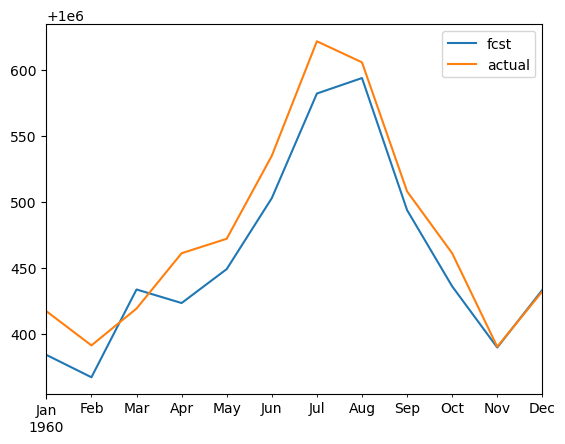

In [36]:
cv1.plot()

In [37]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [38]:
mape(cv1)

2.1457799856912476e-05

## Perform CV with our initial model

In [39]:
warnings.filterwarnings("ignore")
series = y
horizon = 12
start = 120
step_size = 1
order = (1,0,1)
seasonal_order = (0,1,1,12)

cv2 = cross_validate(series, horizon, start, step_size,
                    order = order,
                    seasonal_order = seasonal_order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05707D+03    |proj g|=  2.49082D+03

At iterate    5    f=  5.28008D+00    |proj g|=  6.16918D+00

At iterate   10    f=  4.62751D+00    |proj g|=  1.17766D+00

At iterate   15    f=  4.34220D+00    |proj g|=  1.35395D+00

At iterate   20    f=  3.81594D+00    |proj g|=  3.15778D-01

At iterate   25    f=  3.74884D+00    |proj g|=  7.51359D-03


 This problem is unconstrained.



At iterate   30    f=  3.73628D+00    |proj g|=  5.64653D-02

At iterate   35    f=  3.73162D+00    |proj g|=  7.22165D-02

At iterate   40    f=  3.72973D+00    |proj g|=  3.54358D-02

At iterate   45    f=  3.72910D+00    |proj g|=  2.16580D-03

At iterate   50    f=  3.72880D+00    |proj g|=  2.00164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     55      1     0     0   2.002D-02   3.729D+00
  F =   3.7287995949342476     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  5.36057D+00    |proj g|=  5.40772D+00

At iterate   10    f=  4.59042D+00    |proj g|=  7.14536D-01

At iterate   15    f=  4.03896D+00    |proj g|=  1.21324D-01

At iterate   20    f=  3.76206D+00    |proj g|=  2.27005D-01

At iterate   25    f=  3.74583D+00    |proj g|=  3.25152D-02

At iterate   30    f=  3.73416D+00    |proj g|=  1.32936D-01

At iterate   35    f=  3.73046D+00    |proj g|=  1.30617D-02

At iterate   40    f=  3.72943D+00    |proj g|=  6.06547D-03

At iterate   45    f=  3.72906D+00    |proj g|=  6.94540D-03

At iterate   50    f=  3.72883D+00    |proj g|=  8.58224D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate    5    f=  5.60589D+00    |proj g|=  6.18921D+00

At iterate   10    f=  4.50736D+00    |proj g|=  3.34183D-01

At iterate   15    f=  3.91599D+00    |proj g|=  3.70658D-01

At iterate   20    f=  3.75688D+00    |proj g|=  4.70114D-02

At iterate   25    f=  3.75399D+00    |proj g|=  1.10760D-01

At iterate   30    f=  3.73763D+00    |proj g|=  3.95441D-02

At iterate   35    f=  3.73389D+00    |proj g|=  5.73343D-02

At iterate   40    f=  3.73181D+00    |proj g|=  4.17903D-02

At iterate   45    f=  3.73119D+00    |proj g|=  1.78474D-02

At iterate   50    f=  3.73089D+00    |proj g|=  2.48135D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.



At iterate    5    f=  5.64903D+00    |proj g|=  5.79255D+00

At iterate   10    f=  4.50645D+00    |proj g|=  5.65836D-01

At iterate   15    f=  4.10578D+00    |proj g|=  2.15206D-01

At iterate   20    f=  3.77828D+00    |proj g|=  6.35174D-01

At iterate   25    f=  3.76088D+00    |proj g|=  5.38474D-02

At iterate   30    f=  3.74724D+00    |proj g|=  2.79187D-01

At iterate   35    f=  3.73814D+00    |proj g|=  3.89506D-02

At iterate   40    f=  3.73564D+00    |proj g|=  5.76773D-02

At iterate   45    f=  3.73476D+00    |proj g|=  6.29076D-02

At iterate   50    f=  3.73439D+00    |proj g|=  2.85272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  4.49624D+00    |proj g|=  6.46443D-01

At iterate   15    f=  4.08375D+00    |proj g|=  5.29898D-01

At iterate   20    f=  3.80865D+00    |proj g|=  2.96836D-01

At iterate   25    f=  3.77682D+00    |proj g|=  7.37003D-03

At iterate   30    f=  3.77493D+00    |proj g|=  9.25688D-02

At iterate   35    f=  3.75513D+00    |proj g|=  3.68905D-02

At iterate   40    f=  3.74959D+00    |proj g|=  2.93950D-02

At iterate   45    f=  3.74621D+00    |proj g|=  3.71005D-02

At iterate   50    f=  3.74500D+00    |proj g|=  2.33555D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     56   

 This problem is unconstrained.



At iterate   15    f=  4.11787D+00    |proj g|=  2.78156D-01

At iterate   20    f=  3.80971D+00    |proj g|=  5.41285D-01

At iterate   25    f=  3.77875D+00    |proj g|=  7.54194D-03

At iterate   30    f=  3.75524D+00    |proj g|=  2.01212D-02

At iterate   35    f=  3.74808D+00    |proj g|=  1.36002D-01

At iterate   40    f=  3.74548D+00    |proj g|=  1.10129D-01

At iterate   45    f=  3.74441D+00    |proj g|=  3.38060D-02

At iterate   50    f=  3.74408D+00    |proj g|=  3.46640D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     57      1     0     0   3.466D-02   3.744D+00
  F =   3.74408138953

 This problem is unconstrained.



At iterate   15    f=  4.36965D+00    |proj g|=  2.58301D-01

At iterate   20    f=  3.88233D+00    |proj g|=  4.38118D-01

At iterate   25    f=  3.79482D+00    |proj g|=  2.60870D-02

At iterate   30    f=  3.78642D+00    |proj g|=  1.05796D-01

At iterate   35    f=  3.76437D+00    |proj g|=  4.61285D-03

At iterate   40    f=  3.75914D+00    |proj g|=  9.06347D-02

At iterate   45    f=  3.75656D+00    |proj g|=  6.19581D-02

At iterate   50    f=  3.75549D+00    |proj g|=  1.83066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     54      1     0     0   1.831D-02   3.755D+00
  F =   3.75548511748

 This problem is unconstrained.



At iterate   20    f=  3.86523D+00    |proj g|=  3.28106D-01

At iterate   25    f=  3.81549D+00    |proj g|=  8.86287D-03

At iterate   30    f=  3.81282D+00    |proj g|=  1.21835D-01

At iterate   35    f=  3.78495D+00    |proj g|=  6.61998D-02

At iterate   40    f=  3.77048D+00    |proj g|=  1.25419D-01

At iterate   45    f=  3.76559D+00    |proj g|=  6.39653D-02

At iterate   50    f=  3.76418D+00    |proj g|=  5.07603D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     55      1     0     0   5.076D-02   3.764D+00
  F =   3.7641804102540717     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  3.79815D+00    |proj g|=  1.12326D-01

At iterate   30    f=  3.78036D+00    |proj g|=  7.75548D-02

At iterate   35    f=  3.77615D+00    |proj g|=  6.52118D-02

At iterate   40    f=  3.77447D+00    |proj g|=  5.37092D-02

At iterate   45    f=  3.77351D+00    |proj g|=  2.49084D-03

At iterate   50    f=  3.77309D+00    |proj g|=  2.17401D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     59      1     0     0   2.174D-02   3.773D+00
  F =   3.7730883333023795     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  3.80544D+00    |proj g|=  5.56582D-01

At iterate   30    f=  3.78956D+00    |proj g|=  2.47214D-01

At iterate   35    f=  3.78138D+00    |proj g|=  1.41051D-01

At iterate   40    f=  3.77780D+00    |proj g|=  3.82100D-03

At iterate   45    f=  3.77686D+00    |proj g|=  3.64347D-02

At iterate   50    f=  3.77625D+00    |proj g|=  2.88543D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     52      1     0     0   2.885D-02   3.776D+00
  F =   3.7762456678330474     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   30    f=  3.81447D+00    |proj g|=  5.85148D-01

At iterate   35    f=  3.79304D+00    |proj g|=  8.21462D-02

At iterate   40    f=  3.78385D+00    |proj g|=  4.21122D-02

At iterate   45    f=  3.78180D+00    |proj g|=  4.04355D-02

At iterate   50    f=  3.78074D+00    |proj g|=  1.77617D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     55      1     0     0   1.776D-02   3.781D+00
  F =   3.7807437231228413     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   25    f=  3.86334D+00    |proj g|=  4.78782D-02

At iterate   30    f=  3.86276D+00    |proj g|=  1.18298D-01

At iterate   35    f=  3.84251D+00    |proj g|=  6.43137D-01

At iterate   40    f=  3.81243D+00    |proj g|=  1.35378D-01

At iterate   45    f=  3.80378D+00    |proj g|=  1.23960D-01

At iterate   50    f=  3.79952D+00    |proj g|=  1.74889D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     58      1     0     0   1.749D-02   3.800D+00
  F =   3.7995191159700274     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<Axes: >

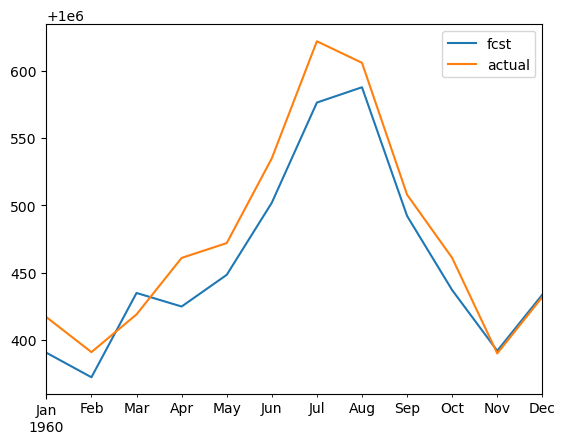

In [40]:
cv2.plot()

In [41]:
mape(cv2)

2.1733966471188317e-05

It looks like our model with the searched parameters was able to predict errors slightly better than the model that we can up with.

## Evaluating and Concluding

We can try to evaluate the best parameters for our models with intuition. To achieve the optimal results, you can search through the parameters to find the lowest value for AIC or BIC criteria.

We're going to select our final model as the SARIMA(0,0,1)(1,1,1,12) as our final model as it achieved a lower value for AIC criteria. Now that we have our generated model, we can try to make some predictions and even forecast cigarette sales for the next couple of months.

In [42]:
model.predict(168) #Predict the number of cigarette sales two years out from the end of our dataset

1963-01-01    1.000523e+06
Freq: MS, dtype: float64

<Axes: title={'center': 'Forecasted Cigarette Sales for the next 2 years'}>

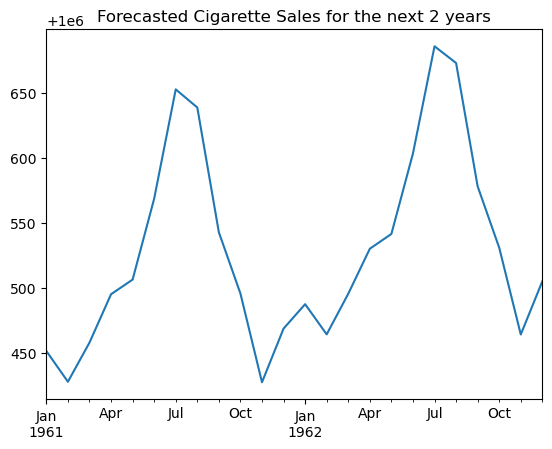

In [43]:
model.forecast(24).plot(title = 'Forecasted Cigarette Sales for the next 2 years')